In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import os

In [2]:
data = pd.read_csv('ETH-EUR_11_11_2017-07_12_2022.csv')

In [3]:
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [4]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-11,256.011322,273.902954,255.673492,269.811371,269.811371,722199256
1,2017-11-12,269.819092,273.739624,255.948730,264.072021,264.072021,1383773530
2,2017-11-13,263.314758,281.949707,263.405121,271.556213,271.556213,893329318
3,2017-11-14,271.596497,290.873871,271.573212,286.394958,286.394958,907354313
4,2017-11-15,286.677399,289.079956,279.644714,282.937531,282.937531,613364441


In [5]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace= True)
data =data.resample('D').mean()
# print(data)

In [6]:
data = data[['Close' ]]

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1853 entries, 2017-11-11 to 2022-12-07
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1853 non-null   float64
dtypes: float64(1)
memory usage: 29.0 KB


In [8]:
from scipy.interpolate import interp1d

In [9]:
data['Close'] = data['Close'].interpolate()# we will fill the null row

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1853 entries, 2017-11-11 to 2022-12-07
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1853 non-null   float64
dtypes: float64(1)
memory usage: 29.0 KB


In [11]:
data.head()

,Close
Date,
2017-11-11,269.811371
2017-11-12,264.072021
2017-11-13,271.556213
2017-11-14,286.394958
2017-11-15,282.937531


In [12]:
df = data.copy()

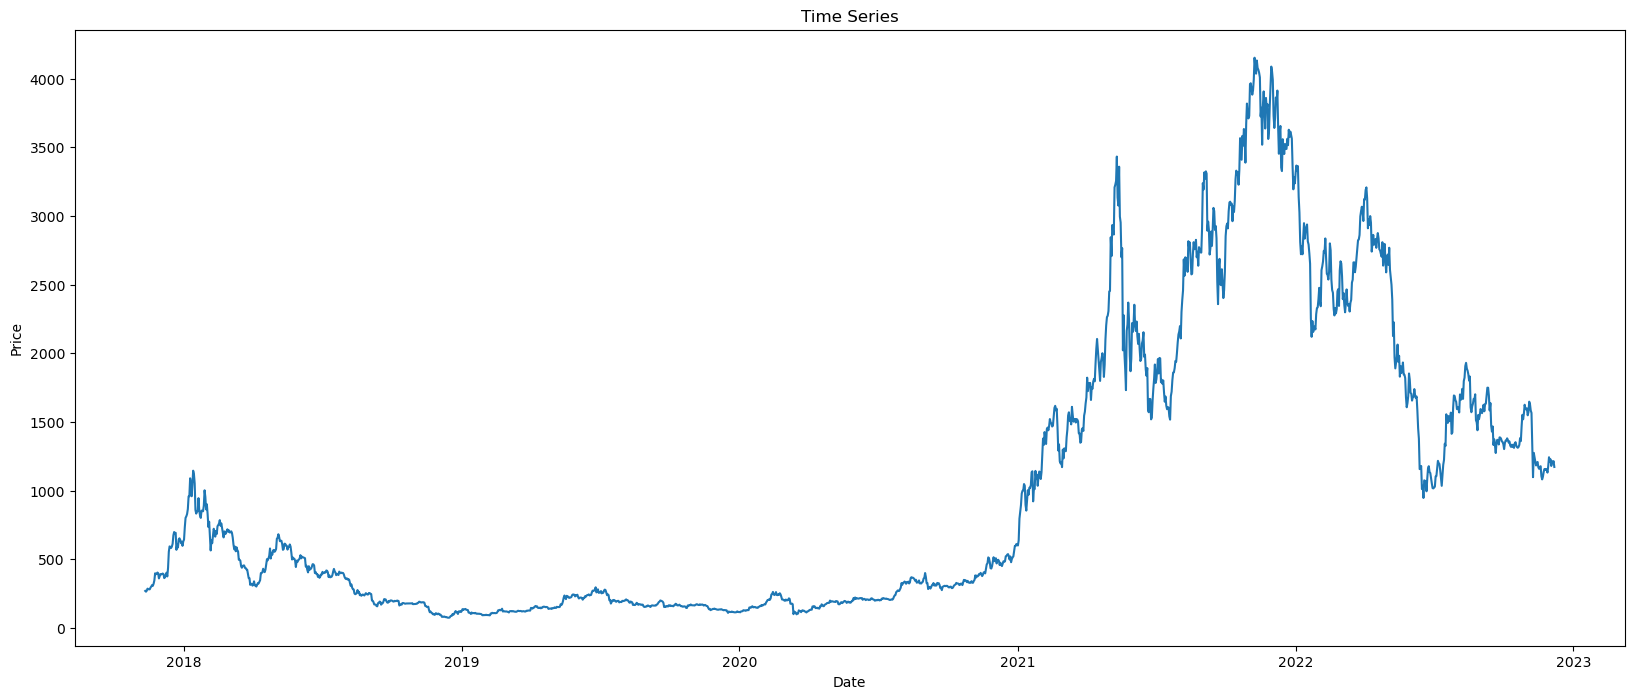

In [13]:
plt.figure(figsize=(20,8))
plt.plot(data)
plt.title('Time Series')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [14]:
data=data.values
data = data.astype('float32')

In [15]:
scaler= MinMaxScaler(feature_range=(-1,1))
sc = scaler.fit_transform(data)

In [16]:
sc

array([[-0.9042362 ],
       [-0.907051  ],
       [-0.9033804 ],
       ...,
       [-0.4479862 ],
       [-0.44074595],
       [-0.46156108]], dtype=float32)

In [17]:
timestep = 30

X= []
Y=[]


for i in range(len(sc)- (timestep)):
    X.append(sc[i:i+timestep])
    Y.append(sc[i+timestep])


X=np.asanyarray(X)
Y=np.asanyarray(Y)


k = 1300
Xtrain = X[:k,:,:]
Xtest = X[k:,:,:]
Ytrain = Y[:k]
Ytest= Y[k:]

In [18]:
print(Xtrain.shape)
print(Xtest.shape)

(1300, 30, 1)
(523, 30, 1)


In [19]:
from keras.layers import Dense,RepeatVector
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [20]:
# model = Sequential()
# model.add(Conv1D(filters=256, kernel_size=2, activation='relu', input_shape=(30,1)))
# model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Flatten())
# model.add(RepeatVector(30))
# model.add(LSTM(128, activation='relu'))
# model.add(Dense(100, activation='relu'))
# model.add(Dense(1))
# model.compile(loss='mse', optimizer='adam')
# model.fit(Xtrain,Ytrain,epochs=300, verbose=0 )


KeyboardInterrupt



In [ ]:
model = Sequential()

model.add(LSTM(32,activation = 'relu', input_shape= (30,1), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(LSTM(32, activation='sigmoid', return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

In [ ]:
history = model.fit(Xtrain,Ytrain,epochs=50, verbose=1)

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Accuracy")

In [ ]:
model

In [ ]:

preds= model.predict(Xtest)
preds = scaler.inverse_transform(preds)


Ytest=np.asanyarray(Ytest)
Ytest=Ytest.reshape(-1,1)
Ytest = scaler.inverse_transform(Ytest)


Ytrain=np.asanyarray(Ytrain)
Ytrain=Ytrain.reshape(-1,1)
Ytrain = scaler.inverse_transform(Ytrain)

mean_squared_error(Ytest,preds)

In [ ]:
plt.figure(figsize=(20,9))
plt.plot(Ytest , 'blue', linewidth=1)
plt.plot(preds,'r' , linewidth=1)
plt.legend(('Test','Predicted'))
plt.title("Price Prediction")
plt.show()

In [ ]:
test = pd.DataFrame(Ytest,columns=['Actual'])
pred = pd.DataFrame(preds,columns=['Predict'])

In [ ]:
results = pd.concat([test,pred],axis=1)

In [ ]:
results.head(20)

In [ ]:
def insert_end(Xin,new_input):
    #print ('Before: \n', Xin , new_input )
    for i in range(timestep-1):
        Xin[:,i,:] = Xin[:,i+1,:]
    Xin[:,timestep-1,:] = new_input
    #print ('After :\n', Xin)
    return Xin

In [ ]:
df

In [ ]:
# this section for unknown future
#we are getting next 30 steps
from datetime import timedelta
future=30
forcast = []
Xin = Xtest[-1:,:,:]
time=[]
for i in range(future):
    out = model.predict(Xin, batch_size=1)
    forcast.append(out[0,0])
    print(forcast)
    Xin = insert_end(Xin,out[0,0])
    time.append(pd.to_datetime(df.index[-1])+timedelta(days=i+1))

In [ ]:
forcasted_output=np.asanyarray(forcast)
forcasted_output=forcasted_output.reshape(-1,1)
forcasted_output = scaler.inverse_transform(forcasted_output)

In [ ]:
forcasted_output = pd.DataFrame(forcasted_output)
date = pd.DataFrame(time)
df_result = pd.concat([date,forcasted_output],axis=1)
df_result.columns = "Date","Forecasted"

In [ ]:
df.columns

In [ ]:
df_result

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Price Prediction')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price USD' ,fontsize=18)
plt.plot(df['Close'][1700:])
plt.plot(df_result.set_index('Date')[['Forecasted']],"r--")